In [1]:
import numpy as np
from IPython.display import display, Markdown
from matplotlib import pyplot as plt
import matplotlib
import torch
import torch.nn as nn
from torch.nn import Sequential
from torch.autograd import Variable
import pandas as pd
from sklearn.utils import shuffle
import time
import pickle

In [2]:
import warnings 
warnings.filterwarnings("ignore")

In [3]:
if torch.cuda.is_available():
        device = "cuda"
else:
    device = "cpu"
print(device)

cuda


## Load Data

In [31]:
df = pd.read_csv(
    "plos_fulldata.csv",
    # names=header,
    index_col=False)

In [32]:
df = df.fillna(0)
# df = df.sample(frac=1)
df = shuffle(df)

### Get first percentile

In [37]:
percentile = df.score.quantile(0.99)
print(percentile)
df = df[df.score >= percentile]
print(df.shape)

254.08
(1900, 80)


In [38]:
print(df.score.min())

254.08


## Normalization

In [7]:
pd.set_option('display.max_colwidth', None)

In [8]:
features = df.iloc[:, 5: 20]
feature_names = df.columns[5: 20]
labels = df[['score']]
# features = (features - features.min()) / (features.max() - features.min())
# labels = (labels - labels.min()) / (labels.max() - labels.min())
features = (features - features.mean()) / features.std()
labels = (labels - labels.mean()) / labels.std()

print(feature_names)

Index(['flesch_reading_score', 'dale_chall_readability_score',
       'total_paragraphs', 'avg_sentences_per_para',
       'len_of_longest_paragraph', 'total_sentences', 'avg_words_per_sentence',
       'len_of_longest_sentence', 'total_words', 'compulsive_hedgers',
       'intensifiers', 'and_frequency', 'vague_words_count',
       'vague_words_frequency', 'polysyllab_count'],
      dtype='object')


In [9]:
print(df.columns)

Index(['Unnamed: 0', 'filename', 'doi_x', 'AccessionID', 'reading_time',
       'flesch_reading_score', 'dale_chall_readability_score',
       'total_paragraphs', 'avg_sentences_per_para',
       'len_of_longest_paragraph', 'total_sentences', 'avg_words_per_sentence',
       'len_of_longest_sentence', 'total_words', 'compulsive_hedgers',
       'intensifiers', 'and_frequency', 'vague_words_count',
       'vague_words_frequency', 'polysyllab_count', 'polysyllab_frequency',
       'title', 'doi_y', 'pmid', 'pmc', 'ads_id', 'uri', 'altmetric_jid',
       'issns', 'journal', 'cohorts', 'abstract', 'abstract_source', 'context',
       'authors', 'type', 'altmetric_id', 'schema', 'is_oa',
       'publisher_subjects', 'cited_by_fbwalls_count', 'cited_by_feeds_count',
       'cited_by_gplus_count', 'cited_by_msm_count', 'cited_by_posts_count',
       'cited_by_tweeters_count', 'cited_by_wikipedia_count',
       'cited_by_accounts_count', 'last_updated', 'score', 'history', 'url',
       'added

In [10]:
train_set, validation_set, test_set = np.split(features, [int(0.6 * len(features)), int(0.8 * len(features))])
train_label, validation_label, test_label = np.split(labels, [int(0.6 * len(features)), int(0.8 * len(features))])

## Model

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "AE"
        self.encoder = nn.Sequential(
            nn.Linear(15, 10), 
            nn.ReLU(),
            nn.Linear(10, 5), 
            nn.ReLU(),
            nn.Linear(5, 3), 
            nn.ReLU(),
            nn.Linear(3, 1),
        )
    def forward(self, x):
        x = self.encoder(x)
        return x

In [12]:
def save_model(model, path):
    # save
    with open(path,'wb') as f:
        pickle.dump(model,f)
        
def load_model(model, path):
    # load
    with open(path, 'rb') as f:
        model = pickle.load(f)
        return model

In [13]:
def evaluate(model, val_set, val_label, criterion, device):
    if device == 'cuda':
        model.to(torch.device('cuda'))
        val_set = Variable(torch.Tensor(val_set.float()).cuda())
        val_label = Variable(torch.Tensor(val_label.float()).cuda())
    else:
        model.to(torch.device('cpu'))
        val_set = Variable(torch.Tensor(val_set.float()).cpu())
        val_label = Variable(torch.Tensor(val_label.float()).cpu())
    
    pred = model(val_set.float())
    loss = criterion(val_label, pred)
    return loss


In [14]:
def train(model, train_set, train_label, val_set, val_label, batch_size = 64, num_epochs=5, learning_rate=0.1):
    train_set = torch.tensor(train_set.values)
    train_label = torch.tensor(train_label.values)
    val_set = torch.tensor(val_set.values)
    val_label = torch.tensor(val_label.values)

    model.to(torch.device(device))
    train_set = train_set.to(device)
    train_label = train_label.to(device)

    """ Training loop. You should update this."""
    print("Training Begin...")
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    ########################################################################
    # Set up numpy arrays of loss and accuracy
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    best_val_loss = float('inf')
    print("Loop epochs...")
    for epoch in range(num_epochs):
        recon = model(train_set.float())
        loss = criterion(recon, train_label.float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss[epoch] = loss.item()
        val_loss[epoch] = evaluate(model, val_set, val_label, criterion, device)
        if val_loss[epoch] <= best_val_loss:
            best_val_loss = val_loss[epoch]
            save_model(model, 'val_best.pkl')
        print("Epoch ", epoch, " ==================================================")
        print("Train loss: {}".format(train_loss[epoch]))
        print("Valid loss: {}".format(val_loss[epoch]))
    
    plt.plot(train_loss)
    plt.plot(val_loss)

Training Begin...
Loop epochs...
Epoch  0  ==================================================
Train loss: 1.5659512281417847
Valid loss: 1.1868869066238403
Epoch  1  ==================================================
Train loss: 1.5655807256698608
Valid loss: 1.1865386962890625
Epoch  2  ==================================================
Train loss: 1.5652103424072266
Valid loss: 1.1861907243728638
Epoch  3  ==================================================
Train loss: 1.5648399591445923
Valid loss: 1.185842752456665
Epoch  4  ==================================================
Train loss: 1.5644696950912476
Valid loss: 1.1854948997497559
Epoch  5  ==================================================
Train loss: 1.5640994310379028
Valid loss: 1.1851472854614258
Epoch  6  ==================================================
Train loss: 1.5637294054031372
Valid loss: 1.1847995519638062
Epoch  7  ==================================================
Train loss: 1.5633596181869507
Valid loss: 1.1

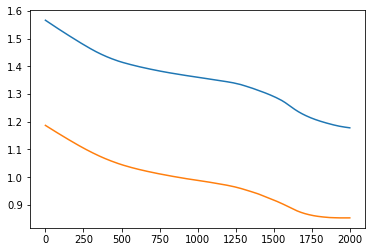

In [15]:
AE = AutoEncoder()
lr = 1e-4
num_epochs = 2000
train(AE, train_set=train_set, train_label=train_label, val_set=validation_set, val_label=validation_label, num_epochs=num_epochs, learning_rate=lr)

In [16]:
def train_w_loader(model, train_set, train_label, val_set, val_label, batch_size = 64, num_epochs=5, learning_rate=0.1):

    train_set = torch.tensor(train_set.values)
    train_label = torch.tensor(train_label.values)
    val_set = torch.tensor(val_set.values)
    val_label = torch.tensor(val_label.values)

    traindata = np.append(train_set, train_label, axis=1)
    print(traindata.shape)

    if device == 'cuda':
        model.to(torch.device('cuda'))
    else:
        model.to(torch.device('cpu'))

    train_loader = torch.utils.data.DataLoader(traindata, batch_size=batch_size, shuffle=True, num_workers=1)   

    """ Training loop. You should update this."""
    print("Training Begin...")
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    ########################################################################
    # Set up numpy arrays of loss and accuracy
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    print("Loop epochs...")
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        start_time = time.time()
        for i, data in enumerate(train_loader):
            data = data.to(device)
            # print(np.array(data).shape)
            d = data[:, 0:15]
            l = data[:, 15]
            pred = model(d.float())
            loss = criterion(pred, l.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss += loss.item()
        end_time = time.time()
        duration = end_time - start_time
        train_loss[epoch] = float(epoch_loss) / (i + 1)
        val_loss[epoch] = evaluate(model, val_set, val_label, criterion, device)
        print("Epoch {} | Train loss: {} | Valid loss: {} | duration: {:.2f}".format(epoch, train_loss[epoch], val_loss[epoch], duration))
    
    plt.plot(train_loss)
    plt.plot(val_loss)

In [17]:
# AE = AutoEncoder()
# lr = 1e-3
# num_epochs = 20
# batch_size = 5000
# train_w_loader(AE, train_set=train_set, train_label=train_label, val_set=validation_set, val_label=validation_label, num_epochs=num_epochs, learning_rate=lr, batch_size=batch_size)

## Preatrained models

In [18]:
from sklearn.metrics import mean_squared_error

## Permutation

In [19]:
from sklearn.metrics import log_loss
import warnings 
warnings.filterwarnings("ignore")

In [20]:
def permutation_importance(model, feature_names, X, y):
    # calculate importance score for each feature by purmutation approach
    # --- Write your code below ---
    model = model.to('cpu')
    base_pred = model(X.float()).cpu()
    base_loss = mean_squared_error(y, base_pred.detach().numpy())
    res = []
    for i in range(X.shape[1]):
        shuffled = torch.Tensor(np.copy(X.cpu()))
        np.random.shuffle(shuffled[:,i])
        shuffle_pred = model(shuffled).cpu()
        shuffled_loss = mean_squared_error(y, shuffle_pred.detach().numpy())
        res.append(shuffled_loss - base_loss)
    # show the top 5 most important features
    # --- Write your code below ---
    loss_name = list(zip(res, feature_names))
    loss_name.sort(key=lambda x: x[0], reverse=True)
    top5 = loss_name[:5]
    features = list(zip(*top5))[1]
    loss_diff = list(zip(*top5))[0]
    plt.figure(figsize=(8, 4))
    plt.barh(features, loss_diff)
    plt.grid(True)
    return top5

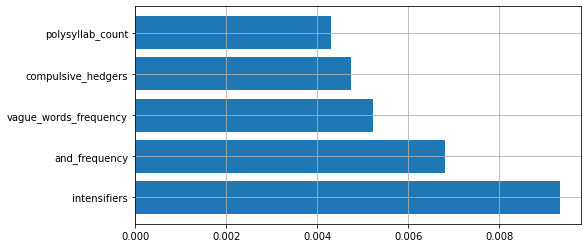

In [21]:
top_5 = permutation_importance(load_model(AE, 'val_best.pkl'), feature_names, torch.tensor(train_set.values), torch.tensor(train_label.values))
selected_feature_names = [x[1] for x in top_5]
selected_features = df[selected_feature_names]
train_set, validation_set, test_set = np.split(selected_features, [int(0.6 * len(selected_features)), int(0.8 * len(selected_features))])
train_label, validation_label, test_label = np.split(labels, [int(0.6 * len(selected_features)), int(0.8 * len(selected_features))])

In [22]:
class AutoEncoderNew(nn.Module):
    def __init__(self):
        super(AutoEncoderNew, self).__init__()
        self.name = "AE"
        self.encoder = nn.Sequential(
            nn.Linear(5, 4), 
            nn.ReLU(),
            nn.Linear(4, 3), 
            nn.ReLU(),
            nn.Linear(3, 2), 
            nn.ReLU(),
            nn.Linear(2, 1), 
        )
    def forward(self, x):
        x = self.encoder(x)
        return x

In [23]:
AE = AutoEncoderNew()
num_epochs = 5000
lr = 5e-4
train(AE, train_set, train_label, validation_set, validation_label, num_epochs=num_epochs, learning_rate=lr)

Training Begin...
Loop epochs...
Epoch  0  ==================================================
Train loss: 127.52928161621094
Valid loss: 116.31610107421875
Epoch  1  ==================================================
Train loss: 123.76972198486328
Valid loss: 112.83944702148438
Epoch  2  ==================================================
Train loss: 120.09142303466797
Valid loss: 109.43818664550781
Epoch  3  ==================================================
Train loss: 116.49433898925781
Valid loss: 106.11318969726562
Epoch  4  ==================================================
Train loss: 112.97792053222656
Valid loss: 102.86560821533203
Epoch  5  ==================================================
Train loss: 109.54301452636719
Valid loss: 99.69544219970703
Epoch  6  ==================================================
Train loss: 106.19019317626953
Valid loss: 96.6034164428711
Epoch  7  ==================================================
Train loss: 102.91875457763672
Valid loss: 93.58

KeyboardInterrupt: 

In [24]:
test_loss = evaluate(load_model(AE, 'val_best.pkl'), torch.tensor(test_set.values), torch.tensor(test_label.values), nn.MSELoss(), 'cpu')
print(test_loss)

tensor(0.5870, grad_fn=<MseLossBackward0>)


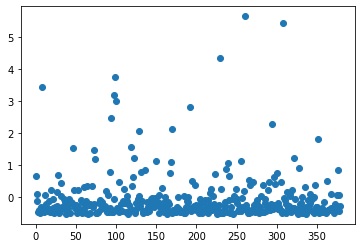

In [27]:
plt.scatter(range(test_label.score.size) ,test_label['score'])

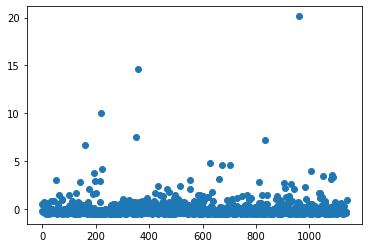

In [26]:
plt.scatter(range(train_label.score.size) ,train_label['score'])